In [44]:
# !pip install --upgrade tensorflow
# !pip install --upgrade tensorflow-gpu
#basic libraries
import os, re, math, cv2, json, warnings, itertools
import numpy as np
import pandas as pd
from pathlib import Path

#plot libraries
import matplotlib.pyplot as plt
import plotly.express as px
from tqdm import tqdm
#utilities library
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc, precision_recall_curve, plot_precision_recall_curve, confusion_matrix

#background library for learning 
import tensorflow as tf
# Model
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras import callbacks


from datetime import datetime, date
import tensorflow.keras.backend as K
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import MobileNetV2
from pandas_profiling import ProfileReport

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from kaggle_datasets import KaggleDatasets

## CPU and GPU activation

In [2]:
# get the current timestamp. This timestamp is used to save the model data with a unique name
now = datetime.now()
today = date.today()
current_time = now.strftime("%H:%M:%S")
timestamp = str(today) + "_" + str(current_time)

# Tensorflow execution optimizations
# Source: https://www.tensorflow.org/guide/mixed_precision & https://www.tensorflow.org/xla
MIXED_PRECISION = True
XLA_ACCELERATE = True
GPUS = 0

GPUS = len(tf.config.experimental.list_physical_devices('GPU'))
if GPUS == 0:
    DEVICE = 'CPU'
else:
    DEVICE = 'GPU'
    if MIXED_PRECISION:
        from tensorflow.keras.mixed_precision import experimental as mixed_precision
        policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
        mixed_precision.set_policy(policy)
        print('Mixed precision enabled')
    if XLA_ACCELERATE:
        tf.config.optimizer.set_jit(True)
        print('Accelerated Linear Algebra enabled')

print("Tensorflow version " + tf.__version__)

2021-11-27 18:26:46.402112: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-27 18:26:46.404448: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-27 18:26:46.446865: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-27 18:26:46.447525: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-11-27 18:26:46.447588: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-11-27 18:26:46.447660: I tensorflow/stream_executor/platform/def

Mixed precision enabled
Accelerated Linear Algebra enabled
Tensorflow version 2.4.1


## Loading in the dataset

In [3]:
""" Helper function to validate the image paths

    Parameters:
        file_path (string): Path to the image 

    Returns:
        The file path if the file exists, otherwise false if the file does not exist

"""
def check_image(file_path):
    img_file = Path(file_path)
    if img_file.is_file():
        return file_path
    return False

BASE_PATH = '../input/siim-isic-melanoma-classification'
PATH_TO_IMAGES = '../input/siim-isic-melanoma-classification/jpeg' 
IMAGE_TYPE = ".jpg"

# Read files
train_df = pd.read_csv(BASE_PATH + '/train.csv')
test_df  = pd.read_csv(BASE_PATH +'/test.csv')


## Exploratory Data analysis

In [4]:
print('Training set contains {} images of {} unique patients, resulting in a ratio of {} images per patient'.format(train_df.shape[0],
                                                                                                                     train_df.patient_id.nunique(),
                                                                                                                     round(train_df.shape[0] / train_df.patient_id.nunique(),2)
                                                                                                                    ))

print('Testing  set contains {} images of {}  unique patients, resulting in a ratio of {} images per patient'.format(test_df.shape[0],
                                                                                                                 test_df.patient_id.nunique(),
                                                                                                                 round(test_df.shape[0] / test_df.patient_id.nunique(),2)
                                                                                                                ))

Training set contains 33126 images of 2056 unique patients, resulting in a ratio of 16.11 images per patient
Testing  set contains 10982 images of 690  unique patients, resulting in a ratio of 15.92 images per patient


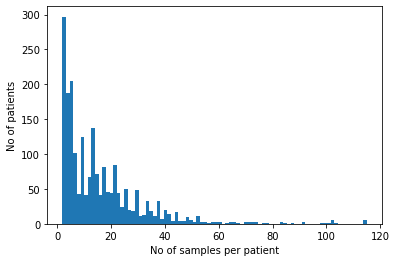

Minimum no of sample taken from  single patient 2
Maximum no of sample taken from  single patient 115
There are  16  samples taken from each patients on average
Median of no. of samples taken from  single patient 12
Mode of no. of samples taken from  single patient 3


In [5]:
image_freq_per_patient = train_df.groupby(['patient_id']).count()['image_name']
plt.hist(image_freq_per_patient.tolist(), bins = image_freq_per_patient.nunique())
plt.xlabel('No of samples per patient')
plt.ylabel('No of patients')
plt.show()
print('Minimum no of sample taken from  single patient', image_freq_per_patient.min())
print('Maximum no of sample taken from  single patient', image_freq_per_patient.max())
print('There are ',int( image_freq_per_patient.mean()), ' samples taken from each patients on average')
print('Median of no. of samples taken from  single patient', int(image_freq_per_patient.median()))
print('Mode of no. of samples taken from  single patient', int(image_freq_per_patient.mode()))

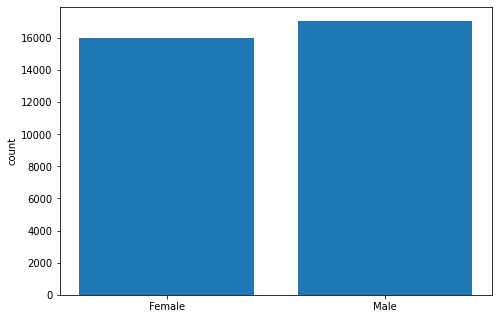

sex
female    15981
male      17080
Name: image_name, dtype: int64

In [6]:
sex_count = train_df.groupby(['sex']).count()['image_name']
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(['Female', 'Male'], sex_count)
plt.ylabel('count')
plt.show()
sex_count

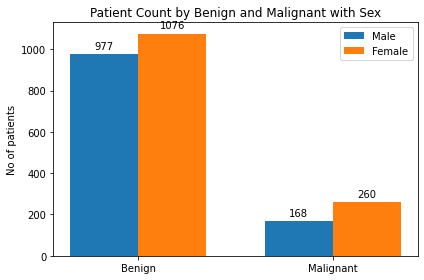

In [7]:
category_sex = train_df.groupby(['sex', 'benign_malignant']).nunique()['patient_id'].tolist()

labels = ['Benign', 'Malignant']
benign_data = category_sex[0:2]
maglignant_data = category_sex[2:4]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, benign_data, width, label='Male')
rects2 = ax.bar(x + width/2, maglignant_data, width, label='Female')
ax.set_ylabel('No of patients')
ax.set_title('Patient Count by Benign and Malignant with Sex')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

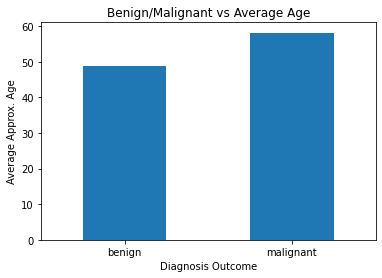

In [8]:
plt.figure()
train_df.groupby(['benign_malignant']).mean()['age_approx'].plot.bar(x = 'Diagnosis Type', y = 'Average age', rot = 0)
plt.title('Benign/Malignant vs Average Age')
plt.xlabel('Diagnosis Outcome')
plt.ylabel('Average Approx. Age')
plt.show()

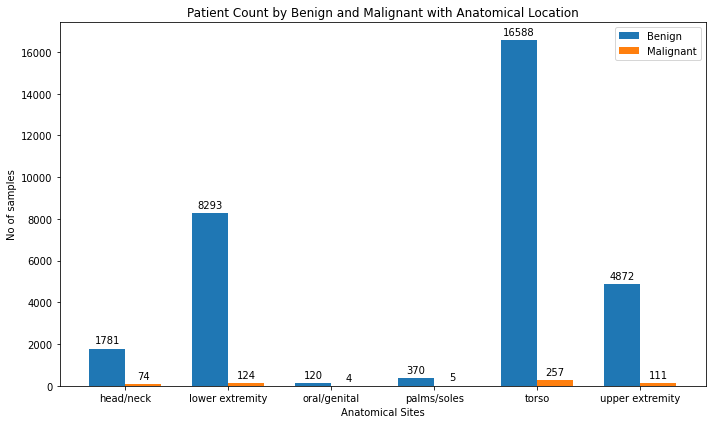

In [9]:
site_vs_diagnosis = train_df.groupby(['anatom_site_general_challenge', 'benign_malignant']).count()['patient_id'].tolist()
labels = ['head/neck', 'lower extremity', 'oral/genital','palms/soles', 'torso', 'upper extremity']
benign_data = site_vs_diagnosis[0:12:2]
maglignant_data = site_vs_diagnosis[1:12:2]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize = (10,6))
rects1 = ax.bar(x - width/2, benign_data, width, label='Benign')
rects2 = ax.bar(x + width/2, maglignant_data, width, label='Malignant')
ax.set_ylabel('No of samples')
ax.set_xlabel('Anatomical Sites')
ax.set_title('Patient Count by Benign and Malignant with Anatomical Location')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()


In [10]:
train_df.groupby(['benign_malignant', 'sex']).nunique()['patient_id']

benign_malignant  sex   
benign            female     977
                  male      1076
malignant         female     168
                  male       260
Name: patient_id, dtype: int64

In [11]:
train_df['image_path'] = train_df['image_name'].apply(lambda x: PATH_TO_IMAGES + "/train/" + x + IMAGE_TYPE)
# check if the we have an image 
train_df['image_path'] = train_df.apply(lambda row : check_image(row['image_path']), axis = 1)
# if we do not have an image we will not include the data
train_df = train_df[train_df['image_path'] != False]
print("valid rows in train", train_df.shape[0])

valid rows in train 33126


### Missing values in dataset

In [12]:
# Encode 'unknowns' as NaNs
train_df['diagnosis'] = train_df.diagnosis.apply(lambda x: np.nan if x == 'unknown' else x)

labels_df = pd.DataFrame(train_df.benign_malignant.value_counts()).reset_index()
labels_df.columns = ['Label','Count']

# Create dataframe counting NaN values per column
nan_df = pd.DataFrame(train_df.isna().sum()).reset_index()
nan_df.columns  = ['Column', 'NaN_Count']
nan_df['NaN_Count'] = nan_df['NaN_Count'].astype('int')
nan_df['NaN_%'] = round(nan_df['NaN_Count']/train_df.shape[0] * 100,1)
nan_df['Type']  = 'Missingness'
nan_df.sort_values('NaN_%', inplace=True)


# Add completeness
for i in range(nan_df.shape[0]):
    complete_df = pd.DataFrame([nan_df.loc[i,'Column'],train_df.shape[0] - nan_df.loc[i,'NaN_Count'],100 - nan_df.loc[i,'NaN_%'], 'Completeness']).T
    complete_df.columns  = ['Column','NaN_Count','NaN_%','Type']
    complete_df['NaN_%'] = complete_df['NaN_%'].astype('int')
    complete_df['NaN_Count'] = complete_df['NaN_Count'].astype('int')
    nan_df = nan_df.append(complete_df, sort=True)
    
    
# Missingness Plot
fig = px.bar(nan_df,
             x='Column',
             y='NaN_%',
             title='percentage of missing data on the Training Set',
             color='Type',
             template='plotly_dark',
             opacity = 0.6,
             color_discrete_sequence=['#dbdbdb','#38cae0'])

fig.update_xaxes(title='Column Name')
fig.update_yaxes(title='NaN Percentage')
fig.show()

In [13]:
# Count NaNs
train_df.isnull().sum()

image_name                           0
patient_id                           0
sex                                 65
age_approx                          68
anatom_site_general_challenge      527
diagnosis                        27124
benign_malignant                     0
target                               0
image_path                           0
dtype: int64

In [14]:
labels_df = pd.DataFrame(train_df.benign_malignant.value_counts()).reset_index()
labels_df.columns = ['Label','Count']

# Create dataframe counting NaN values per column
nan_df = pd.DataFrame(test_df.isna().sum()).reset_index()
nan_df.columns  = ['Column', 'NaN_Count']
nan_df['NaN_Count'] = nan_df['NaN_Count'].astype('int')
nan_df['NaN_%'] = round(nan_df['NaN_Count']/test_df.shape[0] * 100,1)
nan_df['Type']  = 'Missingness'
nan_df.sort_values('NaN_%', inplace=True)


# Add completeness
for i in range(nan_df.shape[0]):
    complete_df = pd.DataFrame([nan_df.loc[i,'Column'],test_df.shape[0] - nan_df.loc[i,'NaN_Count'],100 - nan_df.loc[i,'NaN_%'], 'Completeness']).T
    complete_df.columns  = ['Column','NaN_Count','NaN_%','Type']
    complete_df['NaN_%'] = complete_df['NaN_%'].astype('int')
    complete_df['NaN_Count'] = complete_df['NaN_Count'].astype('int')
    nan_df = nan_df.append(complete_df, sort=True)
    
    
# Missingness Plot
fig = px.bar(nan_df,
             x='Column',
             y='NaN_%',
             title='percentage of missing data on the Testing Set',
             color='Type',
             template='plotly_dark',
             opacity = 0.6,
             color_discrete_sequence=['#dbdbdb','#38cae0'])

fig.update_xaxes(title='Column Name')
fig.update_yaxes(title='NaN Percentage')
fig.show()

In [15]:
# Count NaNs
test_df.isnull().sum()

image_name                         0
patient_id                         0
sex                                0
age_approx                         0
anatom_site_general_challenge    351
dtype: int64

In [16]:
# Summarise data
count_df = labels_df.iloc[::-1]

# Create annotations
annotations = [dict(
            y=count_df.loc[i,'Label'],
            x=count_df.loc[i,'Count'] + 1000,
            text=str(round(count_df.loc[i,'Count']/train_df.shape[0]*100,1))+'%',
            font=dict(
            size=14,
            color="#000000"
            ),
            bordercolor="#c7c7c7",
            borderwidth=1,
            borderpad=4,
            bgcolor="#ffffff",
            opacity=0.95,
            showarrow=False,
        ) for i in range(count_df.shape[0])]



fig = px.bar(labels_df,
             y = 'Label',
             x = 'Count',
             title       = 'Label Distribution',
             template    = 'plotly_dark',
             orientation = 'h',
             opacity     = 0.7,
             color       = 'Label',
             color_discrete_sequence = ['#38cae0','#d1324d'] 
            )


fig.update_layout(showlegend=False, annotations = annotations)
fig.show()

In [17]:
fig = px.histogram(train_df,
             x     = 'age_approx',
             color = 'target',
             color_discrete_sequence = ['#38cae0','#d1324d'],
             barnorm  = 'fraction',
             template = 'plotly_dark',
             opacity  = 0.7,
             title    = 'Impact of Age across Diagnosis'
            )

fig.update_xaxes(title = 'Approximated Age', tickvals = list(range(0,91,5)))
fig.update_yaxes(title = 'Percentage of class total')
fig.show()

In [18]:
parallel_df = train_df.copy()

undersampled_df = pd.concat([parallel_df.query("target == 1"),resample(parallel_df.query("target == 0"),
                                                                       replace   = False,
                                                                       n_samples = 584,
                                                                       random_state = 451)
                            ],axis=0)


keep_list = ['sex','age_approx','anatom_site_general_challenge','target']
fig = px.parallel_categories(undersampled_df[keep_list],
                              color="target",
                              template='plotly_dark',
                              labels={"age_approx": "Approximate Age","sex": "Sex", 'anatom_site_general_challenge':'Anatomical Site','target':'Melanoma'},
                              color_continuous_scale=['#dbdbdb','#38cae0'],
                              title='Categorical Flow'
                             )

fig.update_layout(showlegend=False)
fig.show()

In [19]:
train_df = train_df.dropna()

In [20]:
diagnosis = list(train_df.diagnosis.unique())
diagnosis = [x for x in diagnosis if str(x) != 'unknown']

diagnosis_value_counts = []
for x in diagnosis:
    y = train_df[train_df['diagnosis'] == x]
    diagnosis_value_counts.append(len(y))

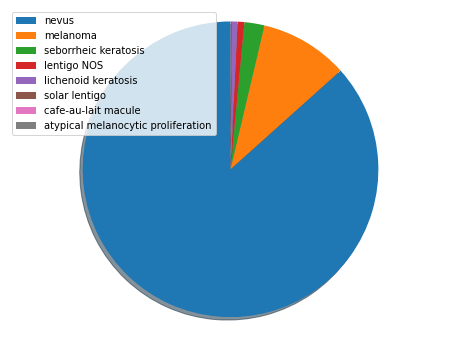

In [21]:
labels = diagnosis
sizes = diagnosis_value_counts
plt.figure(figsize=(8,6))
patches, texts = plt.pie(sizes, shadow=True, startangle=90)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.show()

In [22]:
""" Helper function to plot the pixel intensitiy distribution for rgb images

    Parameters:
        image_path (str) The path to the image
        image_title (str) The title of the plot

    Returns:
        Null
"""
def print_image_dist(image_path, image_title):
    f = plt.figure(figsize=(16,8))
    f.add_subplot(1,2, 1)

    raw_image = plt.imread(image_path)
    plt.imshow(raw_image, cmap='gray')
    plt.colorbar()
    plt.title(image_title)
    print(f"Image dimensions:  {raw_image.shape[0],raw_image.shape[1]}")
    print(f"Maximum pixel value : {raw_image.max():.1f} ; Minimum pixel value:{raw_image.min():.1f}")
    print(f"Mean value of the pixels : {raw_image.mean():.1f} ; Standard deviation : {raw_image.std():.1f}")

    f.add_subplot(1,2, 2)

    _ = plt.hist(raw_image[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
    _ = plt.hist(raw_image[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
    _ = plt.hist(raw_image[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
    _ = plt.xlabel('Intensity Value')
    _ = plt.ylabel('Count')
    _ = plt.legend(['Red_Channel', 'Green_Channel', 'Blue_Channel'])
    plt.show()

### Image Data description

In [23]:
benign_img = train_df[train_df['benign_malignant'] == "benign"].iloc[0]
benign_img

image_name                                                            ISIC_0052212
patient_id                                                              IP_2842074
sex                                                                         female
age_approx                                                                    50.0
anatom_site_general_challenge                                      lower extremity
diagnosis                                                                    nevus
benign_malignant                                                            benign
target                                                                           0
image_path                       ../input/siim-isic-melanoma-classification/jpe...
Name: 2, dtype: object

Image dimensions:  (1053, 1872)
Maximum pixel value : 245.0 ; Minimum pixel value:16.0
Mean value of the pixels : 158.7 ; Standard deviation : 37.4


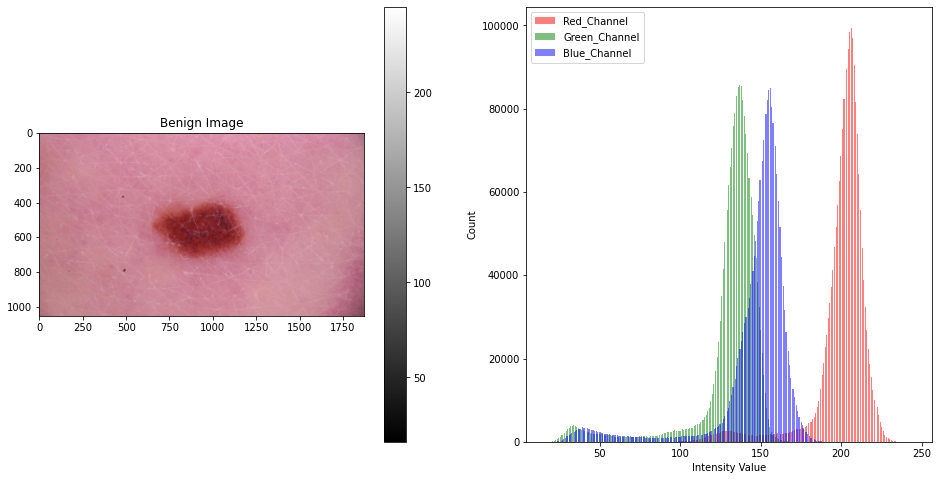

In [24]:
print_image_dist(benign_img['image_path'], 'Benign Image')

In [25]:
malignant_img = train_df[train_df['benign_malignant'] == "malignant"].iloc[0]
malignant_img

image_name                                                            ISIC_0149568
patient_id                                                              IP_0962375
sex                                                                         female
age_approx                                                                    55.0
anatom_site_general_challenge                                      upper extremity
diagnosis                                                                 melanoma
benign_malignant                                                         malignant
target                                                                           1
image_path                       ../input/siim-isic-melanoma-classification/jpe...
Name: 91, dtype: object

Image dimensions:  (4000, 6000)
Maximum pixel value : 255.0 ; Minimum pixel value:0.0
Mean value of the pixels : 174.9 ; Standard deviation : 36.9


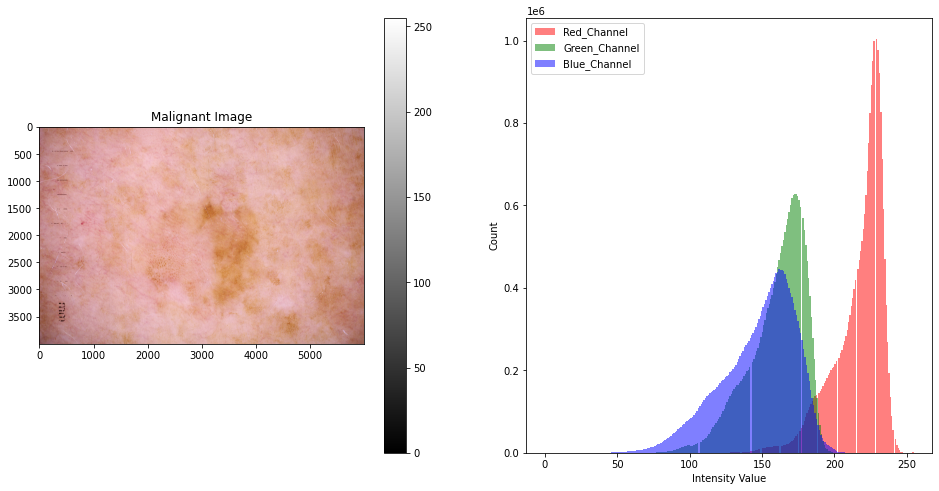

In [26]:
print_image_dist(malignant_img['image_path'], 'Malignant Image')

In [27]:
def prepare_dataframe(df):
    df['sex'] = np.where(df['sex'] == 'female',1,0)
    df = pd.concat([df.drop('anatom_site_general_challenge',axis=1), pd.get_dummies(df['anatom_site_general_challenge'])],axis=1)
    df = df.drop(['benign_malignant','image_name','patient_id','diagnosis', 'image_path'],axis=1)
    df.loc[df['age_approx'].isnull(),'age_approx'] = df['age_approx'].median()
    
    return(df)

def evaluate_predictions(preds, test_labels):
    '''
    Evaluate Predictions Function
    Returns accuracy and auc of the model
    '''
    auroc = roc_auc_score(test_labels.astype('uint8'), preds)
    accur = accuracy_score(test_labels.astype('uint8'), preds >= 0.5)
    print('Accuracy: ' + str(accur))
    print('AUC: ' + str(auroc))

## Logistic Regression evaluation

In [28]:
# Split data
train, probe = train_test_split(prepare_dataframe(train_df),
                                test_size = 0.3,
                                stratify = train_df['target'],
                                random_state = 451
                               )

train_y = train.pop('target')
probe_y = probe.pop('target')

In [29]:
logit_model = LogisticRegression(random_state=451, solver='lbfgs', max_iter=1000)
logit_model.fit(train, train_y)

logit_preds = logit_model.predict_proba(probe)
evaluate_predictions(logit_preds[:,1], probe_y)

Accuracy: 0.9029725182277061
AUC: 0.6941747747100852


In [30]:
fig = px.bar(y = logit_model.coef_.tolist()[0],
       x = probe.columns.tolist(),
       template = 'plotly_dark',
       title = 'Logistic Regression Coefficient Values',
       color = logit_model.coef_.tolist()[0],
       color_continuous_scale = ['#d1285b','#28b5d1'],
       opacity = 0.7
      )

fig.update_yaxes(title = 'Coefficient Value')
fig.update_xaxes(title = 'Variable Name')
fig.show()

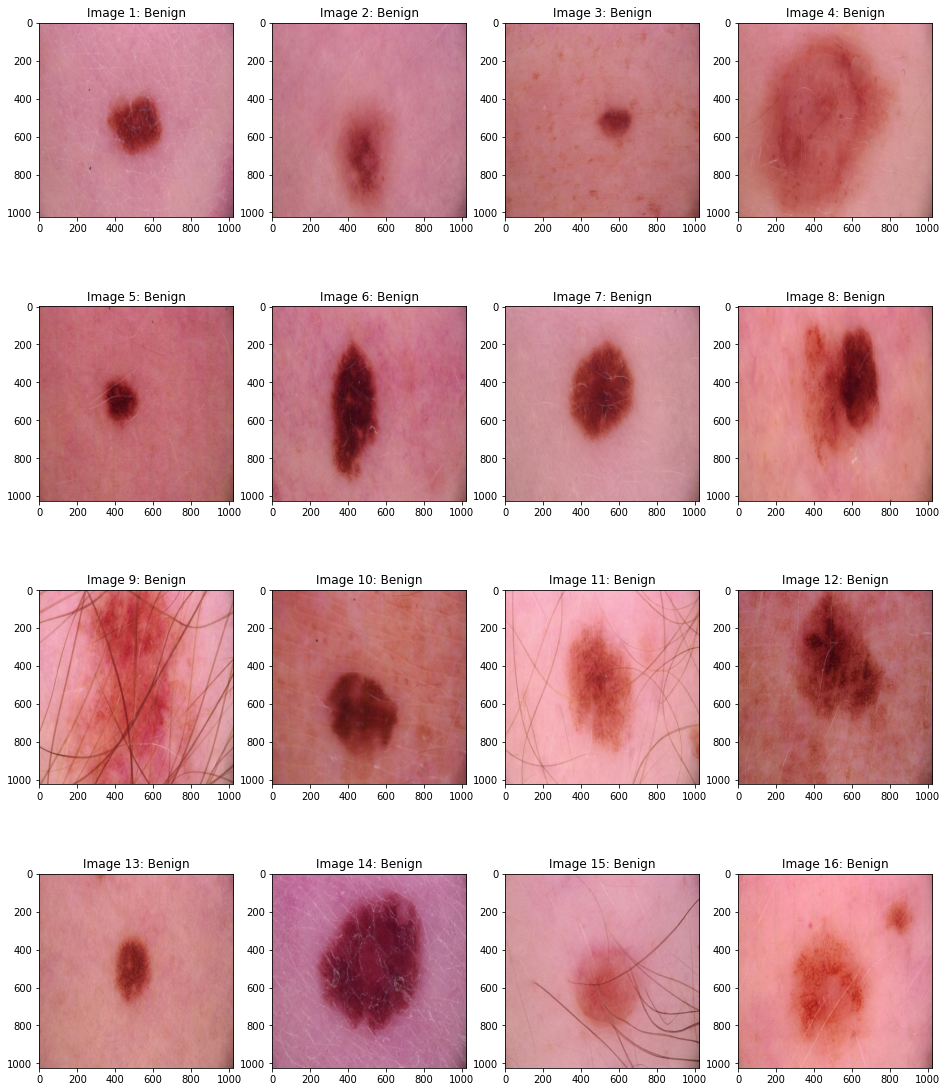

In [31]:
def plot_multiple_images(image_dataframe, rows = 4, columns = 4, figsize = (16, 20), resize=(1024,1024), preprocessing=None, label = 0):
    '''
    Plots Multiple Images
    Reads, resizes, applies preprocessing if desired and plots multiple images from a given dataframe
    '''
    query_string    = 'target == {}'.format(label)
    image_dataframe = image_dataframe.query(query_string).reset_index(drop=True)
    fig = plt.figure(figsize=figsize)
    ax  = []
    base_path = '../input/siim-isic-melanoma-classification/jpeg/train/'
    
    for i in range(rows * columns):
        img = plt.imread(base_path + image_dataframe.loc[i,'image_name'] + '.jpg')
        img = cv2.resize(img, resize)
        
        if preprocessing:
            img = preprocessing(img)
        
        ax.append(fig.add_subplot(rows, columns, i+1) )
        plot_title = "Image {}: {}".format(str(i+1), 'Benign' if label == 0 else 'Malignant') 
        ax[-1].set_title(plot_title)
        plt.imshow(img, alpha=1, cmap='gray')
    
    plt.show()


plot_multiple_images(train_df, label = 0)

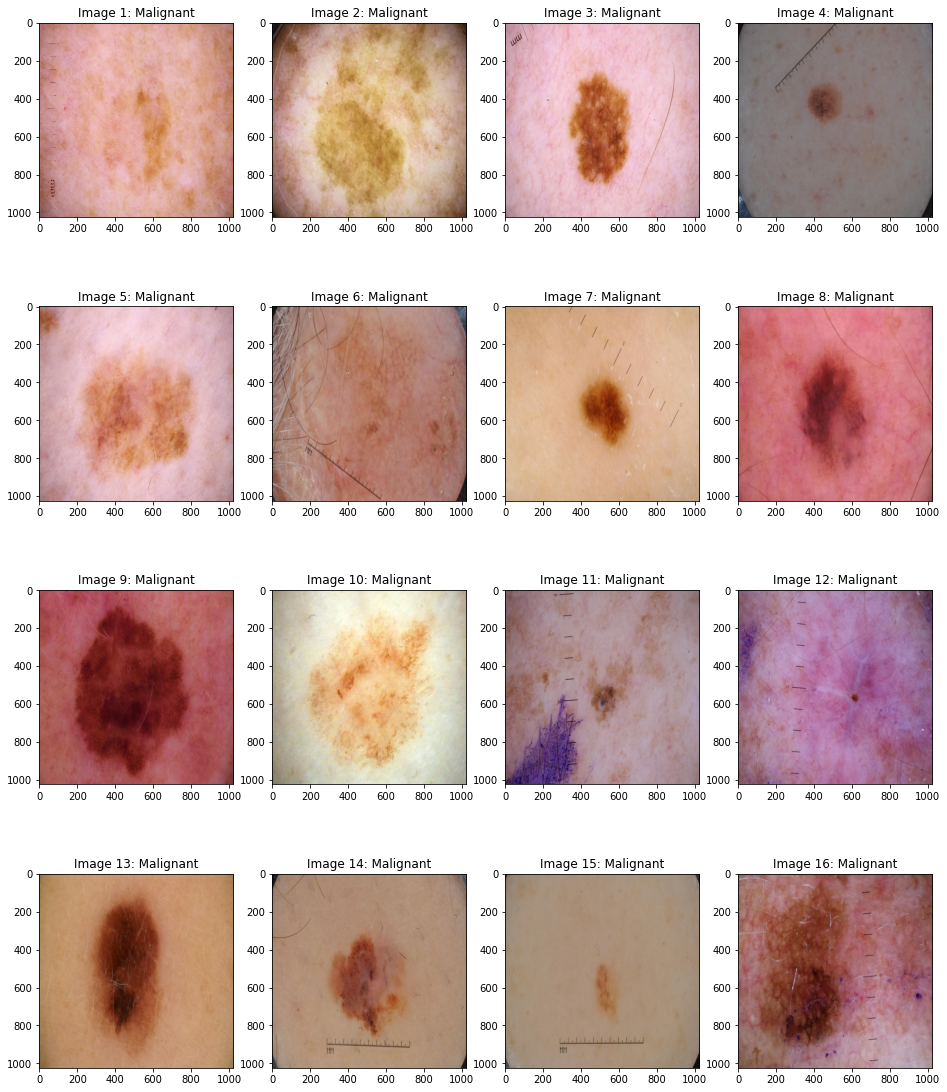

In [32]:
plot_multiple_images(train_df, label = 1)

## Training and Testing dataset preparation

In [33]:
SEED = 1
EPOCHS = 40
BATCH_SIZE = 64
NUM_CLASSES = 2
VERBOSE_LEVEL = 2
SAVE_OUTPUT = True
IMG_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3)

""" Helper function to get the train dataset
"""
def get_train_data():
    # read the data from the train.csv file
    train = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
    # add the image_path to the train set
    train['image_path'] = train['image_name'].apply(lambda x: PATH_TO_IMAGES + "/train/" + x + IMAGE_TYPE)
    # check if the we have an image 
    train['image_path'] = train.apply(lambda row : check_image(row['image_path']), axis = 1)
    # if we do not have an image we will not include the data
    train = train[train['image_path'] != False]
    print("valid rows in train", train.shape[0])
    return train

""" Helper function to get the test dataset
"""
def get_test_data():
    test = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))
    test['image_path'] = test['image_name'].apply(lambda x: PATH_TO_IMAGES + "/test/" + x + IMAGE_TYPE)
    test['image_path'] = test.apply(lambda row : check_image(row['image_path']), axis = 1)
    test = test[test['image_path'] != False]
    print("valid rows in test", test.shape[0])
    return test


""" Factory function to create a validation image data generator

Parameters:
    df (dataframe): Validation dataframe 

Returns:
    Image Data Generator function
"""
def get_validation_gen(df):
    ## prepare images for validation
    val_idg = ImageDataGenerator(rescale=1. / 255.0)
    val_gen = val_idg.flow_from_dataframe(
        seed=SEED,
        dataframe=df,
        directory=None,
        x_col='image_path',
        y_col=['target_0','target_1'],
        class_mode='raw',
        shuffle=False,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        validate_filenames = False
    )

    return val_gen


""" Helper function to create a train and a validation dataset

    Parameters:
    df (dataframe): The dataframe to split
    test_size (int): Size of the validation set
    classToPredict: The target column

    Returns:
    train_data (dataframe)
    val_data (dataframe)
"""
def create_splits(df, test_size, classToPredict):
    train_data, val_data = train_test_split(df,  test_size = test_size, random_state = SEED, stratify = df[classToPredict])
    return train_data, val_data

""" Helper function to plot the auc curve

    Parameters:
        t_y (array): True binary labels
        p_y (array): Target scores

    Returns:
        Null
"""
def plot_auc(t_y, p_y):
    fpr, tpr, thresholds = roc_curve(t_y, p_y, pos_label=1)
    fig, c_ax = plt.subplots(1,1, figsize = (8, 8))
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Target', auc(fpr, tpr)))
    c_ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    
    
    
""" Helper function to plot the history of a tensorflow model

    Parameters:
        history (history object): The history from a tf model
        timestamp (string): The timestamp of the function execution

    Returns:
        Null
"""
def save_history(history, timestamp):
    f = plt.figure()
    f.set_figwidth(15)

    f.add_subplot(1, 2, 1)
    plt.plot(history['val_loss'], label='val loss')
    plt.plot(history['loss'], label='train loss')
    plt.legend()
    plt.title("Model Loss")

    f.add_subplot(1, 2, 2)
    plt.plot(history['val_accuracy'], label='val accuracy')
    plt.plot(history['accuracy'], label='train accuracy')
    plt.legend()
    plt.title("Model Accuracy")

    if SAVE_OUTPUT:
        plt.savefig("./" + timestamp + "-history.png")
        with open("./" + timestamp + "-history.json", 'w') as f:
            json.dump(history, f)

In [34]:
train = get_train_data()
test = get_test_data()

valid rows in train 33126
valid rows in test 10982


## Dataset Augumentation

In [35]:
""" Factory function to create a training image data generator

Parameters:
    df (dataframe): Training dataframe 

Returns:
    Image Data Generator function
"""
def get_training_gen(df):
    ## prepare images for training
    train_idg = ImageDataGenerator(
        rescale = 1 / 255.0,
        horizontal_flip = True, 
        vertical_flip = True, 
        height_shift_range = 0.15, 
        width_shift_range = 0.15,
        shear_range=0.15,
        rotation_range = 90, 
        zoom_range = 0.20,
        fill_mode='nearest'
    )

    train_gen = train_idg.flow_from_dataframe(
        seed=SEED,
        dataframe=df,
        directory=None,
        x_col='image_path',
        y_col=['target_0','target_1'],
        class_mode='raw',
        shuffle=True,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        validate_filenames = False
    )

    return train_gen

## Categorical features transformation

In [36]:
# getting dummy variables for gender
sex_dummies = pd.get_dummies(train['sex'], prefix='sex', dtype="int")
train = pd.concat([train, sex_dummies], axis=1)

sex_dummies = pd.get_dummies(test['sex'], prefix='sex', dtype="int")
test = pd.concat([test, sex_dummies], axis=1)

# getting dummy variables for anatom_site_general_challenge
anatom_dummies = pd.get_dummies(train['anatom_site_general_challenge'], prefix='anatom', dtype="int")
train = pd.concat([train, anatom_dummies], axis=1)

anatom_dummies = pd.get_dummies(test['anatom_site_general_challenge'], prefix='anatom', dtype="int")
test = pd.concat([test, anatom_dummies], axis=1)

# getting dummy variables for target column
target_dummies = pd.get_dummies(train['target'], prefix='target', dtype="int")
train = pd.concat([train, target_dummies], axis=1)

# dropping not useful columns
train.drop(['sex','diagnosis','benign_malignant','anatom_site_general_challenge'], axis=1, inplace=True)
test.drop(['sex','anatom_site_general_challenge'], axis=1, inplace=True)

# replace missing age values with the mean age
train['age_approx'] = train['age_approx'].fillna(int(np.mean(train['age_approx'])))
test['age_approx'] = test['age_approx'].fillna(int(np.mean(test['age_approx'])))

# convert age to int
train['age_approx'] = train['age_approx'].astype('int')
test['age_approx'] = test['age_approx'].astype('int')

print("rows in train", train.shape[0])
print("rows in test", test.shape[0])

rows in train 33126
rows in test 10982


In [37]:
import random
# 1 means 50 / 50 => equal amount of positive and negative cases in Training
# 4 = 20%; 8 = ~11%; 12 = ~8%
balance = 1
p_inds = train[train.target == 1].index.tolist()
np_inds = train[train.target == 0].index.tolist()

np_sample = random.sample(np_inds, balance * len(p_inds))
train = train.loc[p_inds + np_sample]
print("Samples in train", train['target'].sum()/len(train))
print("Remaining rows in train set", len(train))

Samples in train 0.5
Remaining rows in train set 1168


## VGG16 model 

In [38]:
""" Helper function which returns a VGG16 model
"""
def load_pretrained_model(model):
    base_model = model(
        input_shape=INPUT_SHAPE,
        include_top=False,
        weights='imagenet'
    )
    
    # freeze the first 15 layers of the base model. All other layers are trainable.
    for layer in base_model.layers[0:10]:
        layer.trainable = False

    for idx, layer in enumerate(base_model.layers):
        print("layer", idx + 1, ":", layer.name, "is trainable:", layer.trainable)

    return base_model


""" Helper function which returns a tensorflow model
"""
def create_model():
    print("create model")
    
    # Create a new sequentail model and add the pretrained model
    model = Sequential()

    # Add the pretrained model
    model.add(load_pretrained_model(VGG16))  

    # Add a flatten layer to prepare the ouput of the cnn layer for the next layers
    model.add(layers.Flatten())

    # Add a dense (aka. fully-connected) layer. 
    # Add a dropout-layer which may prevent overfitting and improve generalization ability to unseen data.
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(32, activation='relu'))

    # Use the Sigmoid activation function for binary predictions, softmax for n-classes
    # We use the softmax function, because we have two classes (target_0 & target_1)
    model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

    return model

In [39]:
model = create_model()
model.summary()

create model
58892288/58889256 [==============================] - 0s 0us/step
layer 1 : input_1 is trainable: False
layer 2 : block1_conv1 is trainable: False
layer 3 : block1_conv2 is trainable: False
layer 4 : block1_pool is trainable: False
layer 5 : block2_conv1 is trainable: False
layer 6 : block2_conv2 is trainable: False
layer 7 : block2_pool is trainable: False
layer 8 : block3_conv1 is trainable: False
layer 9 : block3_conv2 is trainable: False
layer 10 : block3_conv3 is trainable: False
layer 11 : block3_pool is trainable: False
layer 12 : block4_conv1 is trainable: False
layer 13 : block4_conv2 is trainable: False
layer 14 : block4_conv3 is trainable: False
layer 15 : block4_pool is trainable: False
layer 16 : block5_conv1 is trainable: False
layer 17 : block5_conv2 is trainable: False
layer 18 : block5_conv3 is trainable: False
layer 19 : block5_pool is trainable: False
Model: "sequential"
_________________________________________________________________
Layer (type)       

In [40]:
callback_list = []

# if the model does not improve for 10 epochs, stop the training
stop_early = EarlyStopping(monitor='val_loss', mode='auto', patience=10)
callback_list.append(stop_early)

# if the output of the model should be saved, create a checkpoint callback function
if SAVE_OUTPUT:
    # set the weight path for saving the model
    weight_path = "./" + timestamp + "-model.hdf5"
    # create the model checkpoint callback to save the model wheights to a file
    checkpoint = ModelCheckpoint(
        weight_path,
        save_weights_only=True,
        verbose=VERBOSE_LEVEL,
        save_best_only=True,
        monitor='val_loss',
        overwrite=True,
        mode='auto',
    )
    # append the checkpoint callback to the callback list
    callback_list.append(checkpoint)

In [41]:
# create a training and validation dataset from the train df
train_df, val_df = create_splits(train, 0.2, 'target')

print("rows in train_df", train_df.shape[0])
print("rows in val_df", val_df.shape[0])

# because we do not need the target column anymore we can drop it
train_df.drop(['target'], axis=1, inplace=True)
val_df.drop(['target'], axis=1, inplace=True)

# call the generator functions
train_gen = get_training_gen(train_df)
val_gen = get_validation_gen(val_df)
valX, valY = val_gen.next()

rows in train_df 934
rows in val_df 234
Found 934 non-validated image filenames.
Found 234 non-validated image filenames.


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [45]:
LEARNING_RATE = 1e-4
OPTIMIZER = Adam(lr=LEARNING_RATE)
LOSS = 'binary_crossentropy'
METRICS = [
    'accuracy', 
    'AUC'
] 

model.compile(
    loss=LOSS,
    metrics=METRICS,
    optimizer=OPTIMIZER,
)

# when on a cpu, do not save the model data
if DEVICE == 'CPU':
    print("fit model on cpu")
    history = model.fit(
        train_gen, 
        epochs=EPOCHS, 
        verbose=VERBOSE_LEVEL,
        validation_data=(valX, valY)
    )
else:
    print("fit model on gpu")
    history = model.fit(
        train_gen, 
        epochs=EPOCHS, 
        verbose=VERBOSE_LEVEL,
        callbacks=callback_list, 
        validation_data=(valX, valY),
    )

fit model on gpu


2021-11-27 18:31:16.821429: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-27 18:31:16.826672: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000175000 Hz


Epoch 1/40


2021-11-27 18:31:24.065796: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f5d9d5ed110 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2021-11-27 18:31:24.065852: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2021-11-27 18:31:24.273900: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-11-27 18:31:25.543992: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-11-27 18:31:25.544776: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2021-11-27 18:31:39.238360: I tensorflow/compiler/jit/xla_compilation_cache.cc:333] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


15/15 - 175s - loss: 0.7166 - accuracy: 0.5086 - auc: 0.5191 - val_loss: 0.6885 - val_accuracy: 0.5000 - val_auc: 0.6140

Epoch 00001: val_loss improved from inf to 0.68848, saving model to ./2021-11-27_18:26:46-model.hdf5
Epoch 2/40
15/15 - 131s - loss: 0.7012 - accuracy: 0.5075 - auc: 0.5152 - val_loss: 0.6846 - val_accuracy: 0.4844 - val_auc: 0.6135

Epoch 00002: val_loss improved from 0.68848 to 0.68457, saving model to ./2021-11-27_18:26:46-model.hdf5
Epoch 3/40
15/15 - 128s - loss: 0.6886 - accuracy: 0.5664 - auc: 0.5874 - val_loss: 0.6521 - val_accuracy: 0.7500 - val_auc: 0.8300

Epoch 00003: val_loss improved from 0.68457 to 0.65210, saving model to ./2021-11-27_18:26:46-model.hdf5
Epoch 4/40
15/15 - 134s - loss: 0.6813 - accuracy: 0.5760 - auc: 0.6082 - val_loss: 0.6357 - val_accuracy: 0.8125 - val_auc: 0.8730

Epoch 00004: val_loss improved from 0.65210 to 0.63574, saving model to ./2021-11-27_18:26:46-model.hdf5
Epoch 5/40
15/15 - 133s - loss: 0.6702 - accuracy: 0.6071 - auc

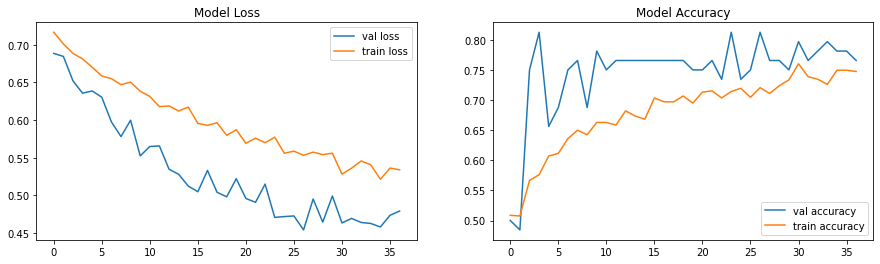

In [46]:
# plot model history
save_history(history.history, timestamp)

100%|██████████| 234/234 [00:46<00:00,  5.02it/s]


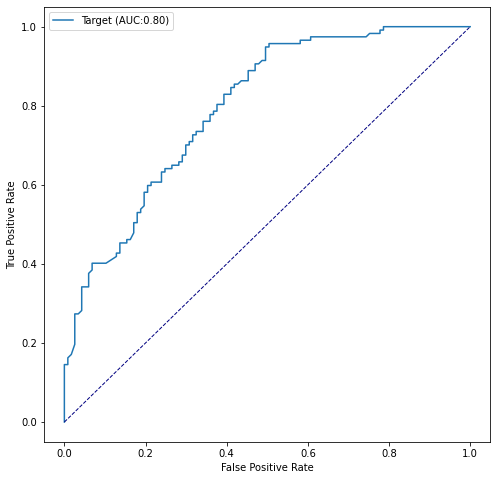

In [47]:
# plot the auc
y_t = [] # true labels
y_p = [] # predictions

# iterate over the validation df and make a prediction for each image
for i in tqdm(range(val_df.shape[0])):
    y_true = val_df.iloc[i].target_1
    image_path = val_df.iloc[i].image_path

    img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img = keras.preprocessing.image.img_to_array(img)
    img = img / 255
    img_array = tf.expand_dims(img, 0)
    y_pred = model.predict(img_array)
    y_pred = tf.nn.softmax(y_pred)[0].numpy()[1]

    y_t.append(y_true)
    y_p.append(y_pred)

plot_auc(y_t, y_p)

In [48]:
""" Helper function to calculate the F1 Score

    Parameters:
        prec (int): precision
        recall (int): recall

    Returns:
        f1 score (int)
"""
def calc_f1(prec, recall):
    return 2*(prec*recall)/(prec+recall) if recall and prec else 0

# calculate the precision, recall and the thresholds
precision, recall, thresholds = precision_recall_curve(y_t, y_p)

# calculate the f1 score
f1score = [calc_f1(precision[i],recall[i]) for i in range(len(thresholds))]

# get the index from the highest f1 score
idx = np.argmax(f1score)

# get the precision, recall, threshold and the f1score
precision = round(precision[idx], 4)
recall = round(recall[idx], 4)
threshold = round(thresholds[idx], 4)
f1score = round(f1score[idx], 4)

print('Precision:', precision)
print('Recall:', recall)
print('Threshold:', threshold)
print('F1 Score:', f1score)

Precision: 0.655
Recall: 0.9573
Threshold: 0.328
F1 Score: 0.7778


In [49]:
""" Helper function turn the model predictions into a binary (0,1) format

    Parameters:
        pred (float): Model prediction

    Returns:
        binary prediction (int)
"""
def pred_to_binary(pred):
    if pred < threshold:
        return 0
    else:
        return 1

y_pred_binary = [pred_to_binary(x) for x in y_p]

In [50]:
# create a confusion matrix
cm =  confusion_matrix(y_t, y_pred_binary)
cm

array([[ 58,  59],
       [  5, 112]])

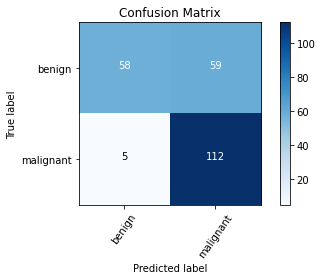

In [51]:
""" Helper function to plot a confusion matrix

    Parameters:
        cm (confusion matrix)

    Returns:
        Null
"""
def plot_confusion_matrix(cm, labels):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=55)
    plt.yticks(tick_marks, labels)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label)

Chance of being malignant: 0.27 %


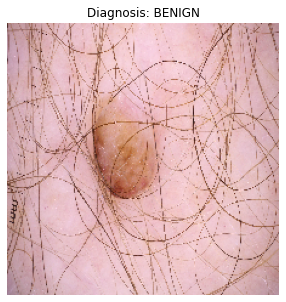

In [52]:
# Show a prediction for a random image
image_path = test.iloc[0].image_path
img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
img = keras.preprocessing.image.img_to_array(img)
img = img / 255
img_array = tf.expand_dims(img, 0)

prediction = np.max(tf.nn.softmax(model.predict(img_array)[0])[1])
print("Chance of being malignant: {:.2f} %".format(prediction))

finding = "Diagnosis: BENIGN"
if prediction > threshold:
    finding = "Diagnosis: MALIGNANT"

x = plt.figure(figsize=(5,5))
x = plt.imshow(img)
x = plt.title(finding)
x = plt.axis("off")

## mobilenet v2

In [53]:
""" Helper function which returns a tensorflow model
"""
def create_model():
    print("create model")
    
    # Create a new sequentail model and add the pretrained model
    model = Sequential()

    # Add the pretrained model
    model.add(load_pretrained_model(MobileNetV2))  

    # Add a flatten layer to prepare the ouput of the cnn layer for the next layers
    model.add(layers.Flatten())

    # Add a dense (aka. fully-connected) layer. 
    # Add a dropout-layer which may prevent overfitting and improve generalization ability to unseen data.
#     model.add(layers.Dense(128, activation='relu'))
#     model.add(layers.Dropout(0.3))

#     model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(32, activation='relu'))

    # Use the Sigmoid activation function for binary predictions, softmax for n-classes
    # We use the softmax function, because we have two classes (target_0 & target_1)
    model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

    return model

In [54]:
model = create_model()
model.summary()

create model
9412608/9406464 [==============================] - 0s 0us/step
layer 1 : input_2 is trainable: False
layer 2 : Conv1 is trainable: False
layer 3 : bn_Conv1 is trainable: False
layer 4 : Conv1_relu is trainable: False
layer 5 : expanded_conv_depthwise is trainable: False
layer 6 : expanded_conv_depthwise_BN is trainable: False
layer 7 : expanded_conv_depthwise_relu is trainable: False
layer 8 : expanded_conv_project is trainable: False
layer 9 : expanded_conv_project_BN is trainable: False
layer 10 : block_1_expand is trainable: False
layer 11 : block_1_expand_BN is trainable: False
layer 12 : block_1_expand_relu is trainable: False
layer 13 : block_1_pad is trainable: False
layer 14 : block_1_depthwise is trainable: False
layer 15 : block_1_depthwise_BN is trainable: False
layer 16 : block_1_depthwise_relu is trainable: False
layer 17 : block_1_project is trainable: False
layer 18 : block_1_project_BN is trainable: False
layer 19 : block_2_expand is trainable: False
layer 

In [55]:
LEARNING_RATE = 1e-4
OPTIMIZER = Adam(lr=LEARNING_RATE)
LOSS = 'binary_crossentropy'
METRICS = [
    'accuracy', 
    'AUC'
] 

model.compile(
    loss=LOSS,
    metrics=METRICS,
    optimizer=OPTIMIZER,
)

# when on a cpu, do not save the model data
if DEVICE == 'CPU':
    print("fit model on cpu")
    history2 = model.fit(
        train_gen, 
        epochs=EPOCHS, 
        verbose=VERBOSE_LEVEL,
        validation_data=(valX, valY)
    )
else:
    print("fit model on gpu")
    history2 = model.fit(
        train_gen, 
        epochs=EPOCHS, 
        verbose=VERBOSE_LEVEL,
        callbacks=callback_list, 
        validation_data=(valX, valY),
    )

fit model on gpu
Epoch 1/40
15/15 - 157s - loss: 0.7430 - accuracy: 0.5974 - auc: 0.6337 - val_loss: 0.7136 - val_accuracy: 0.5625 - val_auc: 0.6346

Epoch 00001: val_loss did not improve from 0.45422
Epoch 2/40
15/15 - 143s - loss: 0.6090 - accuracy: 0.6884 - auc: 0.7483 - val_loss: 0.8196 - val_accuracy: 0.5625 - val_auc: 0.6487

Epoch 00002: val_loss did not improve from 0.45422
Epoch 3/40
15/15 - 130s - loss: 0.5359 - accuracy: 0.7355 - auc: 0.8133 - val_loss: 0.8264 - val_accuracy: 0.6094 - val_auc: 0.6562

Epoch 00003: val_loss did not improve from 0.45422
Epoch 4/40
15/15 - 130s - loss: 0.5216 - accuracy: 0.7281 - auc: 0.8202 - val_loss: 0.8738 - val_accuracy: 0.6094 - val_auc: 0.6539

Epoch 00004: val_loss did not improve from 0.45422
Epoch 5/40
15/15 - 128s - loss: 0.4678 - accuracy: 0.7719 - auc: 0.8605 - val_loss: 1.3301 - val_accuracy: 0.5781 - val_auc: 0.6276

Epoch 00005: val_loss did not improve from 0.45422
Epoch 6/40
15/15 - 127s - loss: 0.4639 - accuracy: 0.7591 - auc

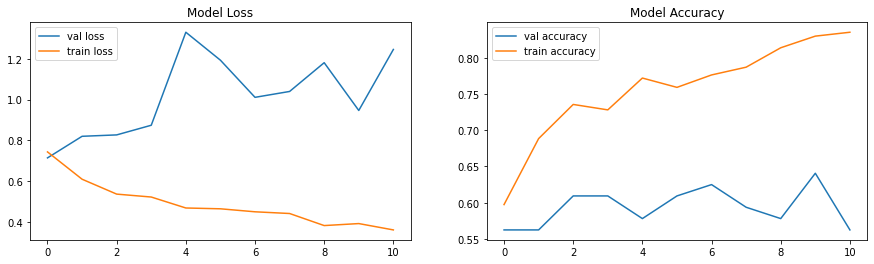

In [56]:
# plot model history
save_history(history2.history, timestamp)

100%|██████████| 234/234 [00:42<00:00,  5.52it/s]


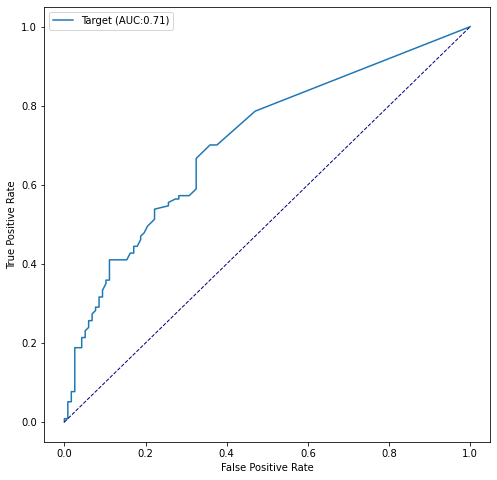

In [57]:
# plot the auc
y_t = [] # true labels
y_p = [] # predictions

# iterate over the validation df and make a prediction for each image
for i in tqdm(range(val_df.shape[0])):
    y_true = val_df.iloc[i].target_1
    image_path = val_df.iloc[i].image_path

    img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img = keras.preprocessing.image.img_to_array(img)
    img = img / 255
    img_array = tf.expand_dims(img, 0)
    y_pred = model.predict(img_array)
    y_pred = tf.nn.softmax(y_pred)[0].numpy()[1]

    y_t.append(y_true)
    y_p.append(y_pred)

plot_auc(y_t, y_p)

In [58]:
# calculate the precision, recall and the thresholds
precision, recall, thresholds = precision_recall_curve(y_t, y_p)

# calculate the f1 score
f1score = [calc_f1(precision[i],recall[i]) for i in range(len(thresholds))]

# get the index from the highest f1 score
idx = np.argmax(f1score)

# get the precision, recall, threshold and the f1score
precision = round(precision[idx], 4)
recall = round(recall[idx], 4)
threshold = round(thresholds[idx], 4)
f1score = round(f1score[idx], 4)

print('Precision:', precision)
print('Recall:', recall)
print('Threshold:', threshold)
print('F1 Score:', f1score)

Precision: 0.6259
Recall: 0.7863
Threshold: 0.2693
F1 Score: 0.697


In [59]:
y_pred_binary = [pred_to_binary(x) for x in y_p]

cm =  confusion_matrix(y_t, y_pred_binary)
cm

array([[62, 55],
       [25, 92]])

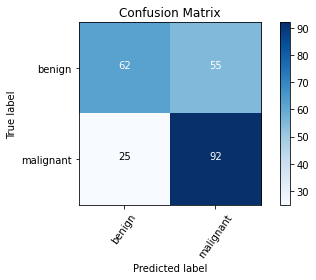

In [60]:
plot_confusion_matrix(cm, cm_plot_label)